# SafeNSound: Initial Log Scaled Mel-Spectrogram Development

In [22]:
import os
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import librosa as lb
# import librosa.display as ld
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
# import sounddevice as sd
from sklearn.model_selection import train_test_split

In [23]:
EMERGENCY_PATH = os.path.join("..", "datasets", "emergency")
ALARMING_PATH = os.path.join("..", "datasets", "alarming")
NORMAL_PATH = os.path.join("..", "datasets", "non-emergency")


def load_audio_files(directory, filename):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")

    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        try:
            wav, sr = lb.load(file_path, sr=16000, mono=True)
            ##wav = tf.convert_to_tensor(wav, dtype=tf.float32)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return wav, sr


In [24]:
def log_scaled_melspectrogram(audio, sample_rate, n_fft=1024, hop_length=512, n_mels=128, max_len=160):
    melspectrogram = lb.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    melS_dB = lb.power_to_db(melspectrogram, ref=np.max)

    if melS_dB.shape[1] < max_len:
        melS_dB = np.pad(melS_dB, ((0,0),(0, max_len - melS_dB.shape[1])), mode='constant')
    else:
        melS_dB = melS_dB[:, :max_len]

    S_norm = (melS_dB - melS_dB.mean()) / (melS_dB.std() + 1e-6)
    # melS_dB = melS_dB[..., np.newaxis]
    delta = lb.feature.delta(S_norm)
    delta2 = lb.feature.delta(S_norm, order=2)

    features = np.stack([S_norm, delta, delta2], axis=-1)

    return features

In [25]:
def augment_audio(audio, sample_rate):
    augmented = [audio]

    audio_stretched = lb.effects.time_stretch(audio, rate=0.8)
    augmented.append(audio_stretched)

    noise = np.random.normal(0, 0.003, audio.shape)
    audio_noise = audio + noise
    augmented.append(audio_noise)
    
    audio_high_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=2)
    audio_low_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=-2)
    augmented.append(audio_high_pitch)
    augmented.append(audio_low_pitch)

    noise_bg = np.random.normal(0, 0.001, audio.shape)
    audio_bg = audio + noise_bg
    augmented.append(audio_bg)

    audio_quiet = audio*0.7
    audio_loud = audio*1.3
    augmented.append(audio_quiet)
    augmented.append(audio_loud)

    return augmented

In [ ]:
X = []
y = []
labels = {"emergency": 2, "alarming": 1, "non-emergency": 0}


for label, idx in labels.items():
    
    main_path = EMERGENCY_PATH if label == "emergency" else ALARMING_PATH if label == "alarming" else NORMAL_PATH if label == "non-emergency" else None
    if main_path is None:
        print(f"Warning: No valid path for label {label}. Skipping...")
        continue

    folder = f"{main_path}"

    if not os.path.exists(folder):
        print(f"Warning: Directory {folder} does not exist. Skipping...")
        continue

    for file in os.listdir(folder):
        if file.endswith(".wav"):
            try:
                wav, sr = load_audio_files(folder, file)
                augmented_audio = augment_audio(wav, sr)
                for augmented in augmented_audio:
                    features = log_scaled_melspectrogram(augmented, sr)
                    X.append(features)
                    y.append(idx)

            except Exception as e:
                print(f"Error processing {file} in {folder}: {e}")
                continue

X = np.array(X)
y = np.array(y)

y = to_categorical(y, num_classes=3)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
def build_cnn(input_shape, num_classes=3):
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Conv Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Flatten + Dense
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = X_train.shape[1:]
print("Input shape:", input_shape)

model = build_cnn(input_shape, num_classes=3)
model.summary()

Input shape: (128, 160, 3)


c:\Users\Acer\Documents\GitHub\SafeNSound-An-IoT-Based-Distress-Signals-Detection-for-Semi-private-Rooms-using-Sound-Sensor\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,337,539 (20.36 MB)

 Trainable params: 5,337,091 (20.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 709ms/step - accuracy: 0.9171 - loss: 0.1704 - val_accuracy: 0.8291 - val_loss: 2.1727
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9116 - loss: 0.2108 - val_accuracy: 0.8376 - val_loss: 2.0823
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.9116 - loss: 0.2266 - val_accuracy: 0.8462 - val_loss: 2.0189
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 986ms/step - accuracy: 0.9190 - loss: 0.1953 - val_accuracy: 0.8462 - val_loss: 1.7160
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 611ms/step - accuracy: 0.9337 - loss: 0.1611 - val_accuracy: 0.8462 - val_loss: 1.2991
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 632ms/step - accuracy: 0.9042 - loss: 0.1940 - val_accuracy: 0.8462 - val_loss: 1.4828
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 622ms/step - accuracy: 0.9355 - loss: 0.1463 - val_accuracy: 0.8718 - val_loss: 1.1883
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 638ms/step - accuracy: 0.9190 - loss: 0.2033 - val_accuracy: 

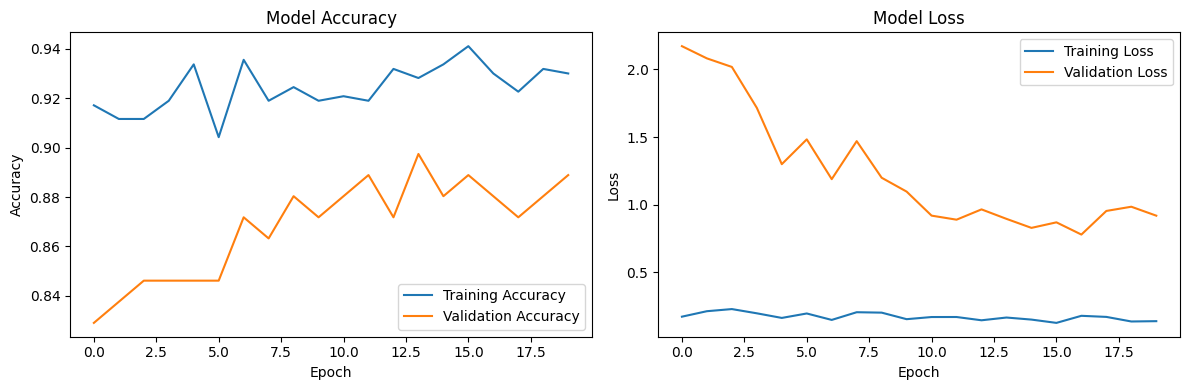

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()